In [11]:
from importlib import reload
from typing import List

import numpy as np
import tensorflow as tf

import spectrum_painting_data as sp_data
import spectrum_painting_plotting as sp_plot
import spectrum_painting_predict as sp_predict
import spectrum_painting_training as sp_training

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Load data

In [12]:
reload(sp_data)

spectrograms = sp_data.load_spectrograms(data_dir="data/matlab",
                                         snr=30,
                                         sample_rate=20000000,
                                         count=44000000)

In [13]:
reload(sp_training)

train_test_sets = sp_training.create_spectrum_painting_train_test_sets(
    spectrograms=spectrograms,
    options=sp_training.SpectrumPaintingTrainingOptions(
        spectrogram_length=2500,
        downsample_resolution=64,
        k=3,
        l=16,
        d=4,
        color_depth=256
    ),
    test_size=0.9)

In [14]:
def plot_confusion_matrix(model_path: str) -> float:
    tflite_model: tf.keras.Model

    # Use a different SNR from the spectrograms intentionally
    with open(model_path, 'rb') as fid:
        tflite_model = fid.read()

    tflite_model_y_predictions: List[int] = []

    for x_aug, x_painted in list(zip(train_test_sets.x_test_augmented, train_test_sets.x_test_painted)):
        tflite_model_y_predictions.append(sp_predict.predict_lite_model(tflite_model, x_aug, x_painted))

    tflite_accuracy = np.sum(train_test_sets.y_test == tflite_model_y_predictions) / len(train_test_sets.y_test)

    print(f"Lite model accuracy = {tflite_accuracy}")
    sp_plot.plot_confusion_matrix(np.asarray(tflite_model_y_predictions), train_test_sets.y_test,
                                  train_test_sets.label_names)

    return tflite_accuracy

Lite model accuracy = 0.9305555555555556


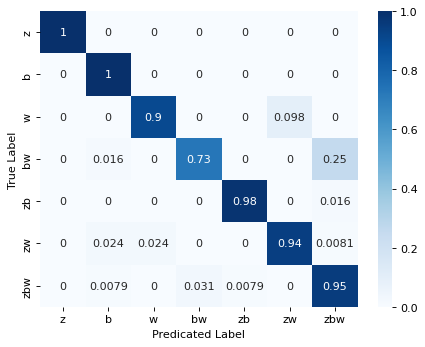

Lite model accuracy = 0.9039351851851852


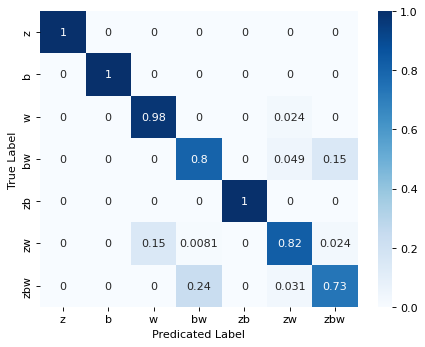

Lite model accuracy = 0.9074074074074074


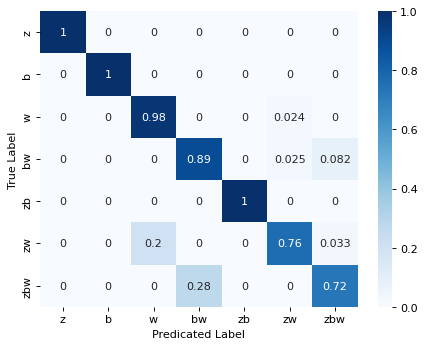

{'snr_30': 0.9305555555555556, 'snr_20': 0.9039351851851852, 'snr_10': 0.9074074074074074}


In [15]:
reload(sp_plot)
reload(sp_predict)

accuracies = {
    "snr_30": plot_confusion_matrix("output/spectrum-painting-model-SNR-30.tflite"),
    "snr_20": plot_confusion_matrix("output/spectrum-painting-model-SNR-20.tflite"),
    "snr_10": plot_confusion_matrix("output/spectrum-painting-model-SNR-10.tflite")
}

print(accuracies)